In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import json
import re
from tqdm import tqdm

In [2]:
inDIR = './cnn_test_results_2cm/'
model_prefix = 'deeplabplus_*'

In [3]:
if not os.path.exists('./results_figs/'):
    os.mkdir('./results_figs/')

In [4]:
for idx, d in enumerate(glob.glob(os.path.join(inDIR, model_prefix))):
    inputs_tmp = '_'.join(os.path.basename(d).split('_')[1:])
    if idx == 0:
        df_bbox_gt = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow = pd.DataFrame(burrow_valid, index=[idx])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel = pd.DataFrame(pixel_valid, index=[idx])
            
        df_burrow_gt = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_ct = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct.insert(0, 'inputs', inputs_tmp)
            
    else:
        df_bbox_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_bbox_gt.csv'))
        df_bbox_gt = pd.concat([df_bbox_gt, df_bbox_gt_tmp])
        
        with open(os.path.join(d, 'test_valid_burrow.json'), 'r') as src:
            burrow_valid = json.load(src)
            burrow_valid['inputs'] = '_'.join(burrow_valid['inputs'])
            df_valid_burrow_tmp = pd.DataFrame(burrow_valid, index=[idx])
            df_valid_burrow = pd.concat([df_valid_burrow, df_valid_burrow_tmp])
        
        with open(os.path.join(d, 'test_valid_pixel.json'), 'r') as src:
            pixel_valid = json.load(src)
            pixel_valid['inputs'] = '_'.join(pixel_valid['inputs'])
            df_valid_pixel_tmp = pd.DataFrame(pixel_valid, index=[idx])
            df_valid_pixel = pd.concat([df_valid_pixel, df_valid_pixel_tmp])
            
        df_burrow_gt_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_gt.csv'))
        df_burrow_gt = pd.concat([df_burrow_gt, df_burrow_gt_tmp])
        
        df_burrow_ct_tmp = pd.read_csv(os.path.join(d, 'test_valid_burrow_count.csv'))
        df_burrow_ct_tmp.insert(0, 'inputs', inputs_tmp)
        df_burrow_ct = pd.concat([df_burrow_ct, df_burrow_ct_tmp])

In [5]:
df_valid_pixel = df_valid_pixel[['model', 'inputs', 'precision', 'recall', 'fscore']]
df_valid_pixel.insert(2, 'n_inputs', df_valid_pixel['inputs'].apply(lambda x: len(x.split('_'))))
df_valid_burrow.insert(2, 'n_inputs', df_valid_burrow['inputs'].apply(lambda x: len(x.split('_'))))
df_burrow_ct.insert(1, 'n_inputs', df_burrow_ct['inputs'].apply(lambda x: len(x.split('_'))))
df_burrow_gt.insert(1, 'n_inputs', df_burrow_gt['inputs'].apply(lambda x: len(x.split('_'))))
df_bbox_gt.insert(1, 'n_inputs', df_bbox_gt['inputs'].apply(lambda x: len(x.split('_'))))

In [6]:
df_valid_pixel['inputs'] = df_valid_pixel['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_valid_burrow['inputs'] = df_valid_burrow['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_ct['inputs'] = df_burrow_ct['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_gt['inputs'] = df_burrow_gt['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_bbox_gt['inputs'] = df_bbox_gt['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))

In [7]:
#df_valid_pixel['fscore_old'] = df_valid_pixel['fscore']
df_valid_pixel['fscore'] = df_valid_pixel.apply(lambda x: ((1 + 1.0) * x['recall'] * x['precision']) / (x['recall'] + 1.0 * x['precision']), axis=1)

In [8]:
beta = 0.75
if False:
    df_valid_pixel['fscore beta=' + str(beta)] = df_valid_pixel.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)
    df_valid_burrow['fscore beta=' + str(beta)] = df_valid_burrow.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)

In [9]:
# subset results to only the combos to be evaluated
#input_list = ['rgb', # RGB only
#              'rgb_ndvi', # RGB+Mutli-spectral
#              'dsm_tpi', # DSM only
#              'rgb_dsm_tpi', # RGB+DSM
#              'rgb_dsm_ndvi_tpi', # RGB+DSM+Multi-spectral
#             ]
#df_valid_pixel = df_valid_pixel[df_valid_pixel['inputs'].isin(input_list)] 
#df_valid_burrow = df_valid_burrow[df_valid_burrow['inputs'].isin(input_list)] 
#df_burrow_ct = df_burrow_ct[df_burrow_ct['inputs'].isin(input_list)] 
#df_burrow_gt = df_burrow_gt[df_burrow_gt['inputs'].isin(input_list)] 
#df_bbox_gt = df_bbox_gt[df_bbox_gt['inputs'].isin(input_list)] 

In [10]:
df_valid_pixel[['model', 'inputs', 'precision', 'recall', 'fscore']].sort_values('fscore', ascending=False).round(2).drop(columns=['model'])

,inputs,precision,recall,fscore
3,RGB + TPI + NDVI,0.84,0.83,0.84
2,RGB + TPI,0.91,0.76,0.83
4,TPI,0.90,0.75,0.82
0,RGB,0.88,0.69,0.78
1,RGB + NDVI,0.82,0.71,0.76


In [11]:
df_valid_burrow[['model', 'inputs', 'precision', 'recall', 'fscore']].sort_values('fscore', ascending=False).round(2).drop(columns=['model'])

,inputs,precision,recall,fscore
4,TPI,0.90,0.84,0.87
2,RGB + TPI,0.86,0.84,0.85
3,RGB + TPI + NDVI,0.88,0.81,0.84
0,RGB,0.70,0.75,0.73
1,RGB + NDVI,0.59,0.76,0.66


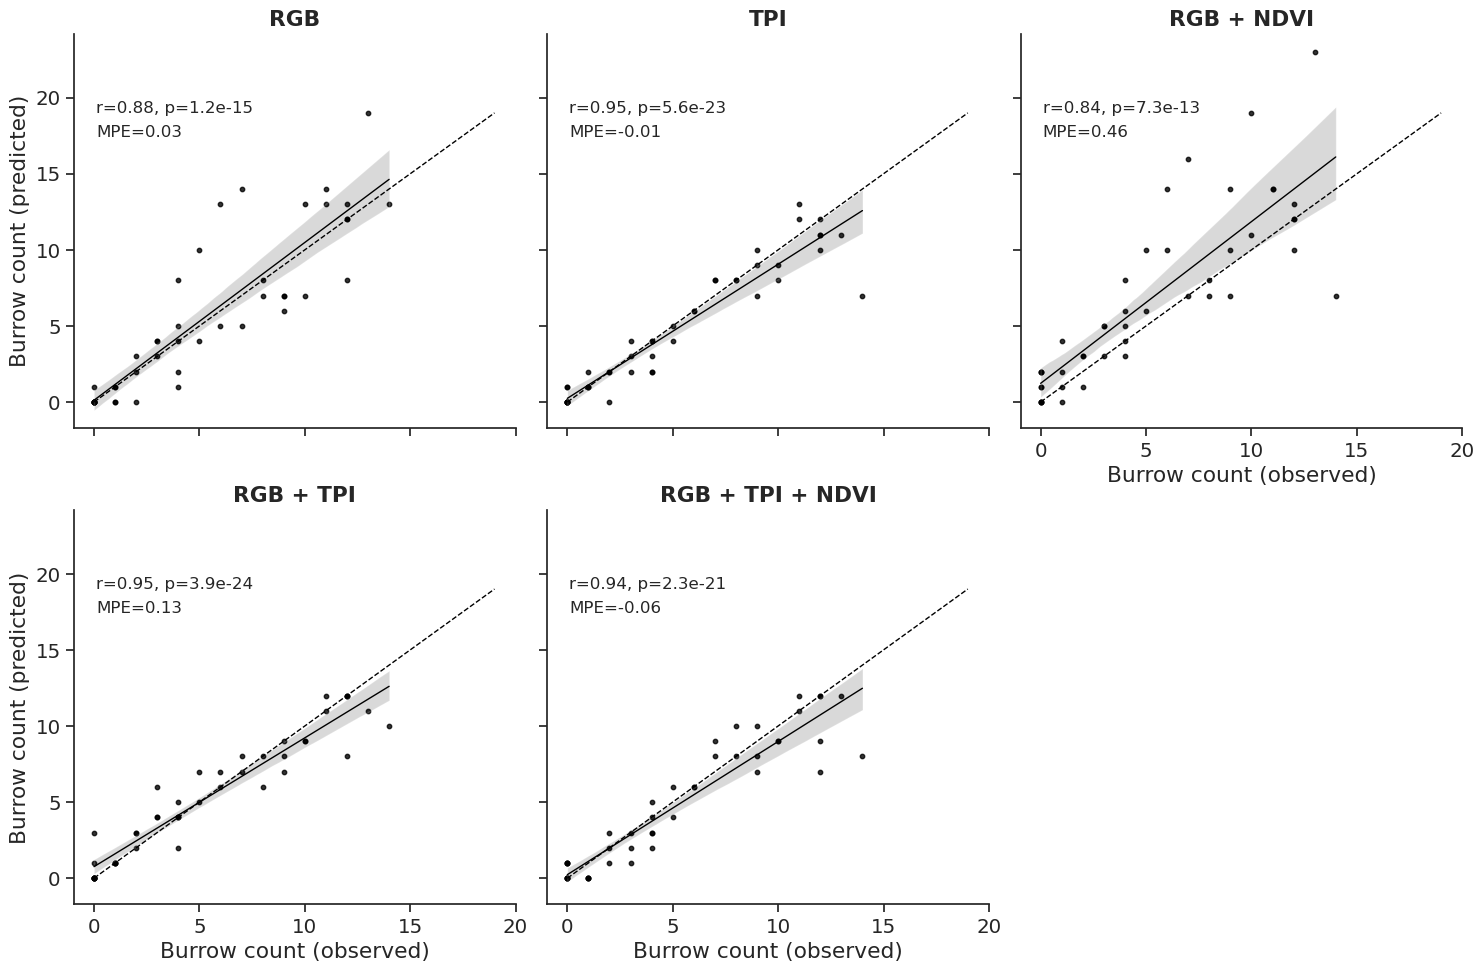

In [12]:
import scipy as sp
sns.set(font_scale = 1.3)
sns.set_style("ticks")
g = sns.lmplot(x='burrow_ct_gt', y='burrow_ct_pred', data=df_burrow_ct.sort_values(['n_inputs', 'inputs']),
               col='inputs', col_wrap=3, 
               scatter_kws={'color': 'black', 's': 10},
               line_kws={'color': 'black', 'linestyle': 'solid', 'linewidth': 1})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['burrow_ct_gt'], data['burrow_ct_pred'])
    mpe = np.mean((data['burrow_ct_pred'] - data['burrow_ct_gt']) / (data['burrow_ct_gt'].apply(lambda x: max(1, x))))
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    ax.text(.05, .74, 'MPE={:.2f}'.format(mpe),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
for ax in g.axes:
    ax.plot(np.arange(0, 20), np.arange(0, 20), c='black', linestyle='dashed', linewidth=1)
    ax.set_ylabel('Burrow count (predicted)')
    ax.set_xlabel('Burrow count (observed)')
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_yticks(np.arange(0, 21, 5))
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')

plt.savefig('./results_figs/burrow_ct_corr.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [13]:
len(df_bbox_gt.Tile.unique())

67

In [14]:
len(df_burrow_gt[df_burrow_gt['is_burrow'] == 1].geometry.unique())

282

In [15]:
len(df_burrow_gt[(df_burrow_gt['is_burrow'] == 1) & (df_burrow_gt['activity'] > 0)].geometry.unique())

218

In [16]:
df_burrow_gt_recall = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())

df_burrow_gt_recall.name = 'Recall'
df_burrow_gt_precision = df_burrow_gt.groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())

df_burrow_gt_precision.name = 'Precision'
df_burrow_gt_recall_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['is_burrow'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_recall_a0.name = 'Recall active'
df_burrow_gt_precision_a0 = df_burrow_gt[df_burrow_gt['activity'] != 0].groupby(['inputs', 'n_inputs']).apply(lambda x: ((x['is_burrow'] == 1) & (x['pred'] == 1)).sum() / 
                                                                       (x['pred'] == 1).sum())#.reset_index(level).rename(columns={0: 'Recall'})

df_burrow_gt_precision_a0.name = 'Precision active'

In [17]:
df_burrow_gt_smry = pd.merge(df_burrow_gt_precision, pd.merge(df_burrow_gt_recall,
                                       pd.merge(df_burrow_gt_precision_a0, df_burrow_gt_recall_a0, left_index=True, right_index=True),
                                       left_index=True, right_index=True),
         left_index=True, right_index=True).sort_values(['n_inputs', 'inputs'])
df_burrow_gt_smry.insert(2, 'F-score', (2 * df_burrow_gt_smry['Recall'] * df_burrow_gt_smry['Precision']) / (df_burrow_gt_smry['Recall'] + df_burrow_gt_smry['Precision']))
df_burrow_gt_smry['F-score active'] = (2 * df_burrow_gt_smry['Recall active'] * df_burrow_gt_smry['Precision active']) / \
                         (df_burrow_gt_smry['Recall active'] + df_burrow_gt_smry['Precision active'])

In [18]:
df_burrow_gt_smry.round(2)

,,Precision,Recall,F-score,Precision active,Recall active,F-score active
inputs,n_inputs,,,,,,
RGB,1,0.94,0.63,0.75,0.93,0.71,0.81
TPI,1,0.95,0.67,0.78,0.95,0.71,0.81
RGB + NDVI,2,0.92,0.67,0.77,0.91,0.73,0.81
RGB + TPI,2,0.95,0.73,0.83,0.94,0.78,0.85
RGB + TPI + NDVI,3,0.96,0.66,0.78,0.95,0.72,0.82


In [19]:
df_burrow_gt_error = df_burrow_gt.groupby(['n_inputs', 'inputs']).apply(lambda x: ((x['is_burrow'] == 0) & (x['pred'] == 1)).sum() / (x['pred'] == 1).sum())
df_burrow_gt_error.name = 'Error rate'
df_burrow_gt_error = df_burrow_gt_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_error['Comment'] = 'Overall'
df_burrow_gt_error = pd.pivot(df_burrow_gt_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_error = df_burrow_gt_error.droplevel(0, axis=1)

In [20]:
df_burrow_gt_nb_error = df_burrow_gt[df_burrow_gt['is_burrow'] == 0].groupby(['inputs', 
                                                                              'n_inputs', 
                                                                              'Comment']).apply(lambda x: ((x['pred'] == 1)).sum() / len(x['pred']))
df_burrow_gt_nb_error.name = 'Error rate'
df_burrow_gt_nb_error = df_burrow_gt_nb_error.reset_index().sort_values(['n_inputs', 'inputs'])
df_burrow_gt_nb_error = pd.pivot(df_burrow_gt_nb_error, index='Comment', columns=['n_inputs', 'inputs'], values='Error rate')
df_burrow_gt_nb_error = df_burrow_gt_nb_error.droplevel(0, axis=1)
df_burrow_gt_nb_error.insert(0, 'n', df_burrow_gt[df_burrow_gt['is_burrow'] == 0]['Comment'].value_counts() // len(df_burrow_gt['inputs'].unique()))

In [21]:
df_burrow_gt_error.insert(0, 'n', df_burrow_gt_nb_error['n'].sum())

In [22]:
df_error_fnl = pd.concat([df_burrow_gt_nb_error, df_burrow_gt_error]).round(2)
df_error_fnl

inputs,n,RGB,TPI,RGB + NDVI,RGB + TPI,RGB + TPI + NDVI
Comment,,,,,,
ant,67,0.07,0.01,0.18,0.03,0.03
den,8,0.38,0.50,0.12,0.50,0.12
dig,6,0.33,0.17,0.17,0.17,0.17
old,27,0.07,0.11,0.07,0.11,0.15
Overall,108,0.06,0.05,0.08,0.05,0.04


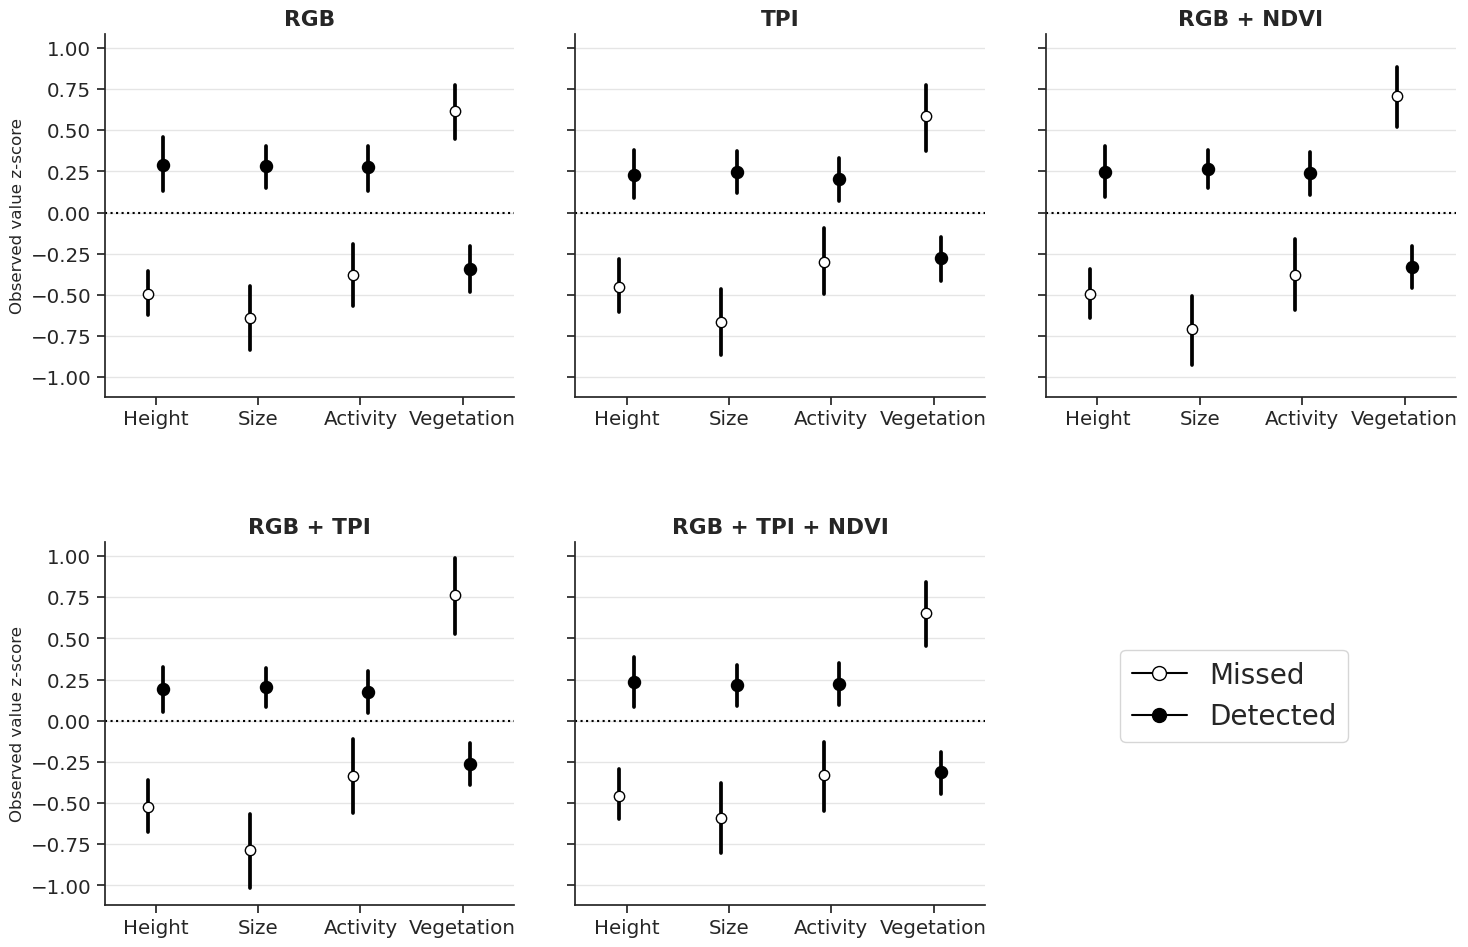

In [23]:
plt.close()
from matplotlib.lines import Line2D
from scipy import stats
sns.set(font_scale = 1.3)
sns.set_style("ticks")
df_burrow_gt_std = df_burrow_gt[df_burrow_gt['is_burrow'] == 1].copy()
df_burrow_gt_std['height'] = stats.zscore(df_burrow_gt_std['height'])
df_burrow_gt_std['size'] = stats.zscore(df_burrow_gt_std['size'])
df_burrow_gt_std['activity'] = stats.zscore(df_burrow_gt_std['activity'])
df_burrow_gt_std['vegetation'] = stats.zscore(df_burrow_gt_std['vegetation'])
df_burrow_gt_long = pd.melt(df_burrow_gt_std,
                               id_vars=['n_inputs', 'inputs', 'Pasture', 'is_burrow', 'pred', 'label'],
                               value_vars=['height', 'size', 'activity', 'vegetation'])
df_burrow_gt_long['inputs'] = df_burrow_gt_long['inputs'].apply(lambda x: re.sub('_', ' + ', x.upper()))
df_burrow_gt_long['variable'] = df_burrow_gt_long['variable'].apply(lambda x: x.capitalize())
#df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value'] = 3.0 - df_burrow_gt_long.loc[df_burrow_gt_long['variable'] == 'vegetation', 'value']
g=sns.catplot(x='variable', y='value', data=df_burrow_gt_long.sort_values(['n_inputs', 'inputs']), kind='point',
                hue='pred', col='inputs', col_wrap=3,
                join=False, dodge=0.15, markers='o', scale=1.1, 
              sharex=False,
              palette={0.0: 'black', 1.0: 'black'}, ec=['black', 'none'], legend=False)
for ax in g.axes:
    #ax.set_ylim(0, 3)
    ax.legend().remove()
    p1=ax.get_children()[4]
    p1.set_facecolor('white')
    p1.set_linewidth(1)
    ax.set_xlabel('')
    ax.set_ylabel('Observed value z-score', fontsize=12)
    ax.axhline(y=0, linestyle='dotted', color='black')
    ax.grid(True, axis='y', alpha=0.5)
plt.subplots_adjust(hspace=0.4, wspace=0.15)
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Missed',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]
g.set_titles("{col_name}", weight='bold')  # use this argument literally
g.fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.75, 0.0, 0.25, 0.35), fontsize=20)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

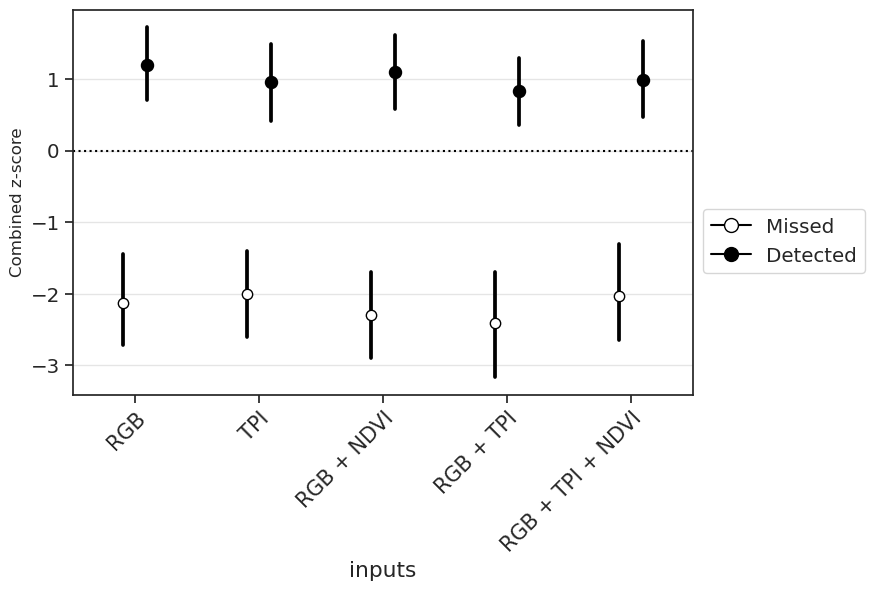

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
df_burrow_gt_std['score'] = df_burrow_gt_std.apply(lambda x: x['height'] + x['size'] + x['activity'] + (-1.0 * x['vegetation']), axis=1)
sns.pointplot(x='inputs', y='score', data=df_burrow_gt_std.sort_values(['n_inputs', 'inputs']),
            hue='pred', ax=ax, dodge=0.2, join=False, ci=99, markers='o', scale=1.1, 
              palette={0.0: 'black', 1.0: 'black'}, fc=['white', 'black'], ec=['black', 'none'])
ax.legend().remove()
ax.axhline(y=0, linestyle='dotted', color='black')
p1=ax.get_children()[5]
p1.set_facecolor('white')
p1.set_linewidth(1)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Missed',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]
ax.set_ylabel('Combined z-score', fontsize=12)
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.9, 0.0, 0.5, 0.5))
ax.grid(True, axis='y', alpha=0.5)
plt.savefig('./results_figs/missed_burrow_characteristics_zscore_comb.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [25]:
df_bbox_gt = df_bbox_gt[df_bbox_gt['Type'] != 'non_burrows'].copy()

In [26]:
def val_metrics(df, prefix='pred'):
    #(group_label, df) = grouping
    precision = df[prefix + '_correct_ct'].sum() / df[prefix + '_ct'].sum()
    recall = df[prefix + '_correct_ct'].sum() / df['gt_ct'].sum()
    fscore = (2 * precision * recall) / (precision + recall)
    if len(df.name) == 1:
        return pd.DataFrame({'Precision': precision,
                             'Recall': recall,
                             'F-score': fscore},
                            index=[len(df.name.split('_'))])
    else:
        return pd.DataFrame({'Precision': precision,
                             'Recall': recall,
                             'F-score': fscore},
                            index=[len(df.name[0].split('_'))])
#df_bbox.groupby('inputs').apply(val_metrics)

In [27]:
df_bbox_gt_pred_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby(['inputs', 'n_inputs']).apply(val_metrics).reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')
df_bbox_gt_label_smry = df_bbox_gt[df_bbox_gt['Digitize'] == 1].groupby(['inputs', 'n_inputs']).apply(val_metrics, prefix='label').reset_index().rename(columns={'level_1': 'n_inputs'}).sort_values('n_inputs')

In [28]:
df_bbox_gt_label_smry.round(2)

,inputs,n_inputs,level_2,Precision,Recall,F-score
0,RGB,1,1,0.78,0.77,0.77
4,TPI,1,1,0.78,0.77,0.77
1,RGB + NDVI,2,1,0.78,0.77,0.77
2,RGB + TPI,2,1,0.78,0.77,0.77
3,RGB + TPI + NDVI,3,1,0.78,0.77,0.77


In [29]:
len(df_bbox_gt[df_bbox_gt['Digitize'] == 1]['Tile'].unique())

13

In [30]:
df_bbox_gt_pred_smry.round(2)

,inputs,n_inputs,level_2,Precision,Recall,F-score
0,RGB,1,1,0.67,0.68,0.67
4,TPI,1,1,0.86,0.72,0.79
1,RGB + NDVI,2,1,0.64,0.75,0.69
2,RGB + TPI,2,1,0.84,0.79,0.82
3,RGB + TPI + NDVI,3,1,0.85,0.72,0.78


In [31]:
df_downscaled_test = pd.read_csv('./cnn_test_results_downscaled/downscaled_model_test_validation.csv')

In [32]:
df_downscaled_test['inputs'] = df_downscaled_test['inputs'].apply(lambda x: re.sub(',', ' + ', x.upper()))

In [33]:
df_valid_burrow['test_resolution'] = 2.0

In [34]:
df_downscaled_test = pd.concat([df_downscaled_test, df_valid_burrow])

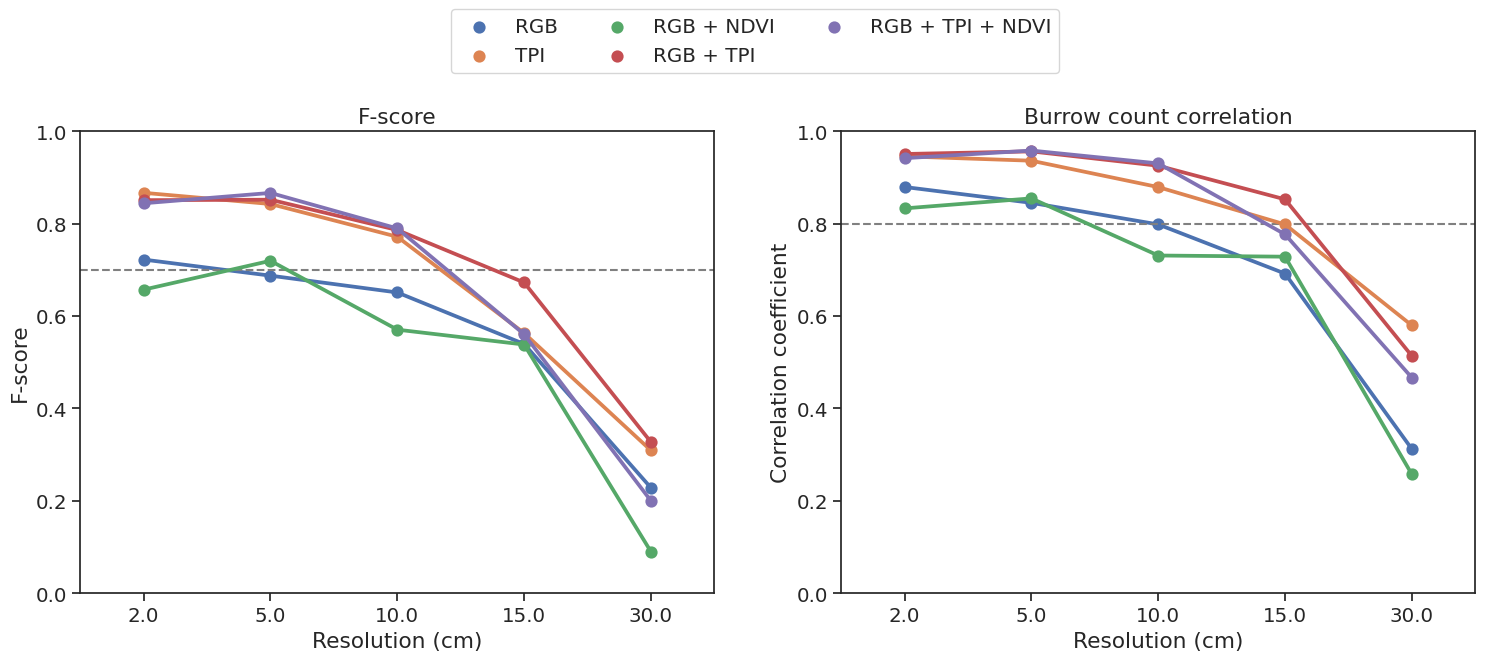

In [35]:
sns.set(font_scale = 1.3)
sns.set_style("ticks")
fig, axs = plt.subplots(figsize=(18, 6), ncols=2)
sns.pointplot(x='test_resolution', y='fscore', 
            hue='inputs', hue_order=['RGB', 'TPI', 'RGB + NDVI', 
                                     'RGB + TPI', 'RGB + TPI + NDVI'],
            data=df_downscaled_test.sort_values('model_resolution'),
            ci=None,
            ax=axs[0], show_legend=False, zorder=10)
#sns.pointplot(x='test_resolution', y='fscore', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[0], show_legend=False,
#            linestyles='dotted')
axs[0].set_title('F-score')
axs[0].set_ylabel('F-score')
axs[0].axhline(y=0.70, linestyle='dashed', color='grey', zorder=1)

sns.pointplot(x='test_resolution', y='correlation', 
            hue='inputs', hue_order=['RGB', 'TPI', 'RGB + NDVI', 
                                     'RGB + TPI', 'RGB + TPI + NDVI'],
            data=df_downscaled_test.sort_values('test_resolution'),
            ci=None,
            ax=axs[1], show_legend=False, zorder=10)
#sns.pointplot(x='test_resolution', y='correlation', 
#            hue='inputs',
#            data=df_best_downscaled_test.sort_values('test_resolution'),
#            ci=None,
#            ax=axs[1], show_legend=False,
#            linestyles='dotted')
axs[1].set_title('Burrow count correlation')
axs[1].set_ylabel('Correlation coefficient')
axs[1].axhline(y=0.80, linestyle='dashed', color='grey', zorder=1)
for ax in axs:
    ax.set_xlabel('Resolution (cm)')
    ax.legend().remove()
    ax.set_ylim((0, 1.0))
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0, 0, 1.0, 1.1), ncol=3)
plt.savefig('./results_figs/cnn_results_downscaled_test_validation.png',
            dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [16]:
col_val_list = glob.glob('cnn_test_results_downscaled/downscaled_colony*')

In [17]:
for idx, f in enumerate(col_val_list):
    if idx == 0:
        df_col_val = pd.read_csv(f)
    else:
        df_col_val = pd.concat([df_col_val, pd.read_csv(f)])
#df_col_val['resolution'] = df_col_val['resolution'].apply(lambda x: int(re.sub('cm', '', x)))

In [18]:
df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0)].reset_index()

,index,Pasture,yrs_thresh,conn_thresh,ha_obs,ha_pred,jscore,ha_obs_july,ha_pred_july,jscore_july,inputs,resolution
0,2,22EW,0,3,173.8425,166.7500,0.936698,189.5550,37.9100,0.199931,rgb,10cm
1,26,29-30,0,3,0.6975,59.7650,0.010783,8.0550,90.7875,0.079774,rgb,10cm
2,50,5W,0,3,45.9200,59.7250,0.584358,57.7125,53.2675,0.607649,rgb,10cm
3,74,CN,0,3,117.3525,112.6925,0.832626,140.7600,31.5725,0.202285,rgb,10cm
4,2,22EW,0,3,173.8425,84.3350,0.482905,189.5550,5.4225,0.028606,rgb,15cm
5,26,29-30,0,3,0.6975,16.3600,0.016689,8.0550,16.3875,0.176251,rgb,15cm
6,50,5W,0,3,45.9200,29.9325,0.376259,57.7125,27.8925,0.287923,rgb,15cm
7,74,CN,0,3,117.3525,29.6600,0.235815,140.7600,5.7850,0.035160,rgb,15cm
8,2,22EW,0,3,173.8425,162.3175,0.889760,189.5550,148.0650,0.776527,rgb,5cm
9,26,29-30,0,3,0.6975,37.2525,0.017017,8.0550,13.7100,0.224645,rgb,5cm


/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


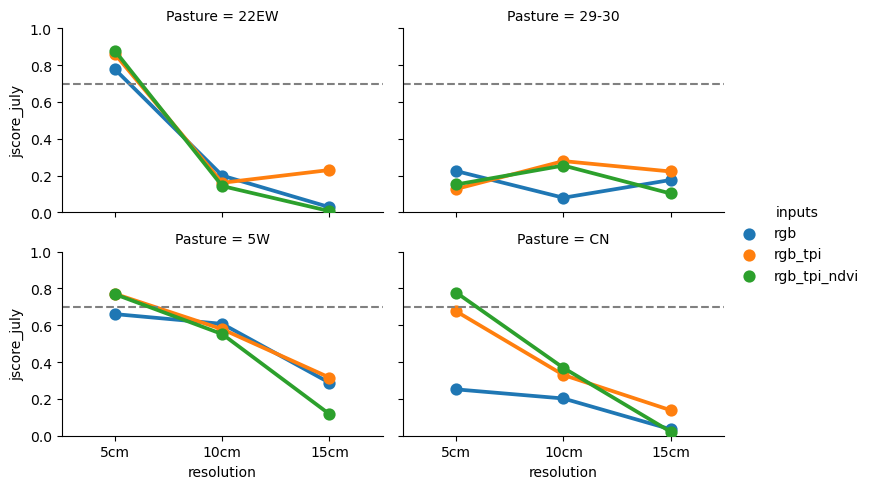

In [23]:
#fig, axs
g1 = sns.factorplot(data=df_col_val[(df_col_val['conn_thresh'] == 3) & (df_col_val['yrs_thresh'] == 0)].reset_index(),
                  hue='inputs', col='Pasture', col_wrap=2, height=2.5, aspect=1.5,
                  x='resolution', y='jscore_july', order=['5cm', '10cm', '15cm'], ci=None, join=True)
#g.add_legend()
for ax in g1.axes.flatten():
    ax.set_ylim((0, 1.0))
    ax.axhline(y=0.70, linestyle='dashed', color='grey')
plt.show()

In [109]:
inputs_sub = 'rgb_tpi'
res_sub = '5cm'
df_col_val_long = pd.melt(df_col_val[(df_col_val['yrs_thresh'] == 0) &
                                     (df_col_val['inputs'] == inputs_sub) &
                                     (df_col_val['resolution'] == res_sub)],
                      id_vars=['Pasture', 'conn_thresh'], 
                      value_vars=['ha_pred'],
                      value_name='hectares')
df_pred_wide = pd.pivot(df_col_val[(df_col_val['yrs_thresh'] == 0) &
                                   (df_col_val['inputs'] == inputs_sub) &
                                   (df_col_val['resolution'] == res_sub)],
                       index='Pasture',
                       columns='conn_thresh',
                       values=['ha_pred', 'ha_pred_july'])
df_pred_wide.index = pd.Categorical(values=df_pred_wide.index, categories=['22EW', 'CN', '5W', '29-30'], ordered=True)

In [110]:
past_ordered = df_pred_wide.index.categories.values

In [111]:
for i in ['ha_pred', 'ha_pred_july']:
    for c in range(2, 7):
        df_pred_wide.loc[:, (i, c)] = df_pred_wide.loc[:, (i, c)] - df_pred_wide[[(i, x) for x in range(1, c)]].sum(axis=1)

In [112]:
df_pred_wide = df_pred_wide.unstack().unstack(level=1)#.reset_index(level=1, drop=True).rename_axis('names').reset_index()

In [113]:
df_pred_wide = df_pred_wide.reorder_levels([1, 0])
df_pred_wide.index = df_pred_wide.index.set_names('month', level=1)

In [114]:
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

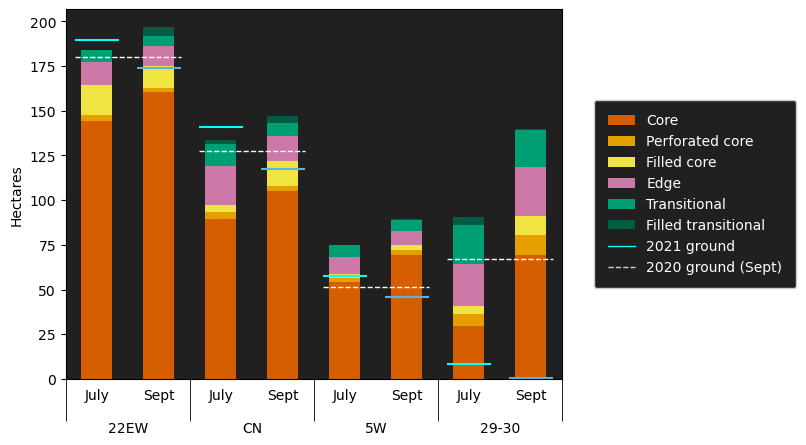

In [115]:
cmap_conn = ListedColormap(['#D55E00', '#E69F00', '#F0E442', '#CC79A7', '#009E73', '#005c42'])
ax = df_pred_wide.sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False).plot.bar(
    stacked=True, cmap=cmap_conn)
ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
#ax.xticks(rotation=0)
for idx, past in enumerate(past_ordered):
    idx = idx*2
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs_july'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='cyan')
for idx, past in enumerate(past_ordered):
    idx = idx*2+1
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 1)]['ha_obs'].values[0],
               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
               color='white', linestyle='dashed', linewidth=1)
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [Line2D([0], [0], color='cyan', lw=1, linestyle='solid'),
                                                 Line2D([0], [0], color='lightgrey', lw=1, linestyle='dashed')],
    labels=['Core', 'Perforated core', 'Filled core', 
                   'Edge', 'Transitional', 'Filled transitional', '2021 ground', '2020 ground (Sept)'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0)
ax.set_xlabel('')
cur_xticks = past_ordered
xticks = []
for i in [0, 2, 4, 6]:
    for x in list(np.arange(0, 1.5, 0.5)):
        xticks.append(i + x)
xlbls = ['July', '\n\n' + cur_xticks[0], 'Sept',
         'July', '\n\n' + cur_xticks[1], 'Sept',
         'July', '\n\n' + cur_xticks[2], 'Sept',
         'July', '\n\n' + cur_xticks[3], 'Sept']

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], minor=True)
ax.set_xticklabels(xlbls, rotation=0)
#ax.set_xlim( -0.5, 7.5 )

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params( axis='x', which='minor', direction='out', length=30 )
ax.tick_params( axis='x', which='major', bottom=False, top=False)
plt.show()

In [116]:
df_pred_wide['Core'] = df_pred_wide[[1, 2, 3]].sum(axis=1)
df_pred_wide['Edge'] = df_pred_wide[4]
df_pred_wide['Transitional'] = df_pred_wide[[5, 6]].sum(axis=1)

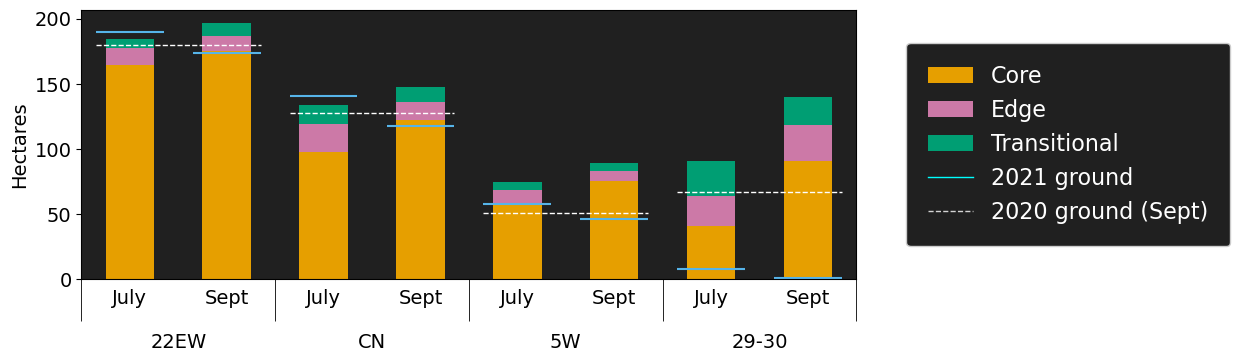

In [135]:
cmap_conn_simp = ListedColormap(['#E69F00', '#CC79A7', '#009E73'])
ax = df_pred_wide[['Core', 'Edge', 'Transitional']].sort_index(level=1, ascending=False).sort_index(level=0, sort_remaining=False).plot.bar(
    stacked=True, cmap=cmap_conn_simp, figsize=(10, 3.5))
ax.set_facecolor('#202020')
ax.set_ylabel('Hectares')
#ax.xticks(rotation=0)
for idx, past in enumerate(past_ordered):
    idx = idx*2
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs_july'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    idx = idx*2+1
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 0)]['ha_obs'].values[0],
               xmin=idx-0.35, xmax=idx+0.35,
               color='#56B4E9')
for idx, past in enumerate(past_ordered):
    plt.hlines(y=df_col_val[(df_col_val['Pasture'] == past) &
                        (df_col_val['yrs_thresh'] == 1)]['ha_obs'].values[0],
               xmin=idx*2-0.35, xmax=idx*2+1+0.35,
               color='white', linestyle='dashed', linewidth=1)
ax.legend(
    handles=ax.get_legend_handles_labels()[0] + [Line2D([0], [0], color='cyan', lw=1, linestyle='solid'),
                                                 Line2D([0], [0], color='lightgrey', lw=1, linestyle='dashed')],
    labels=['Core', 'Edge', 'Transitional', '2021 ground', '2020 ground (Sept)'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderpad=1,
           facecolor='#202020', labelcolor='white', framealpha=1.0, fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Hectares', fontsize=14)
cur_xticks = past_ordered
xticks = []
for i in [0, 2, 4, 6]:
    for x in list(np.arange(0, 1.5, 0.5)):
        xticks.append(i + x)
xlbls = ['July', '\n\n' + cur_xticks[0], 'Sept',
         'July', '\n\n' + cur_xticks[1], 'Sept',
         'July', '\n\n' + cur_xticks[2], 'Sept',
         'July', '\n\n' + cur_xticks[3], 'Sept']

ax.set_xticks(xticks, major=True)
ax.set_xticks([-0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], minor=True)
ax.set_xticklabels(xlbls, rotation=0, fontsize=14)
#ax.set_xlim( -0.5, 7.5 )

#ax.grid( 'off', axis='x' )
#ax.grid( 'off', axis='x', which='minor' )

# vertical alignment of xtick labels
#va = [ 0, -.05, 0, -.05, -.05, -.05 ]
#for t, y in zip( ax.get_xticklabels( ), va ):
#    t.set_y( y )

ax.tick_params(axis='x', which='minor', direction='out', length=30)
ax.tick_params(axis='x', which='major', bottom=False, top=False)
ax.tick_params(axis='y', labelsize=14)
plt.savefig('results_figs/pred_vs_obs_ha_' + inputs_sub + '_' + res_sub + '.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
df_out['box_x'] = df_out.apply(lambda x: -1 if x['yrs_old'] == 1 else x['yrs_active'], axis=1)
df_out['box_x_july'] = df_out.apply(lambda x: -1 if x['yrs_old_july'] == 1 else x['yrs_active_july'], axis=1)
df_out_boxplot = df_out.loc[df_out['box_x'].notnull()].copy()

In [45]:
df_out_boxplot['box_x'] = df_out_boxplot['box_x'].astype('int')
df_out_boxplot.loc[df_out_boxplot['box_x'] == 0, 'box_x'] = 'N/A'

df_out_boxplot['box_x_july'] = df_out_boxplot['box_x_july'].astype('int')
df_out_boxplot.loc[df_out_boxplot['box_x_july'] == 0, 'box_x_july'] = 'N/A'

Text(0.5, 1.0, 'September')

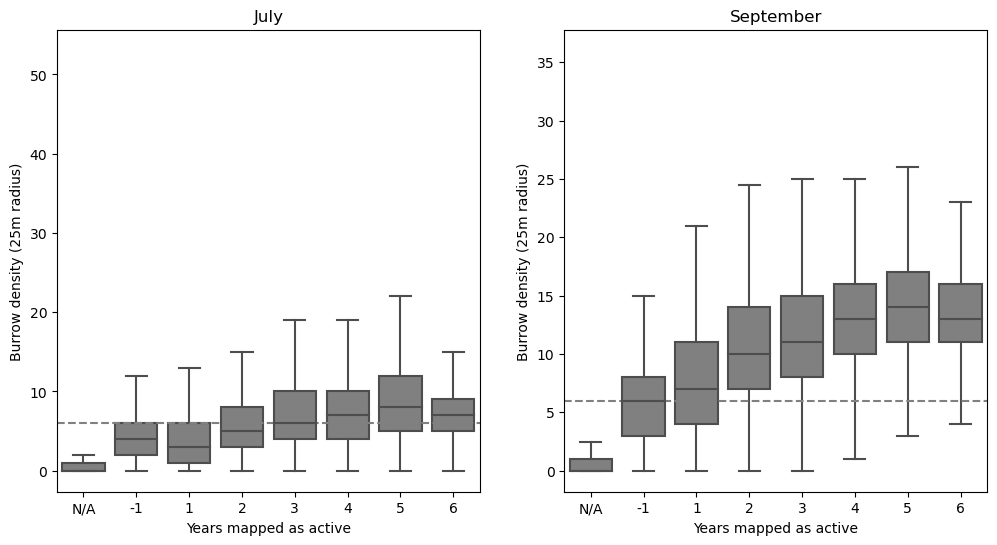

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.boxplot(x='box_x_july', y='pts_sum_july', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[0])
axs[0].set_ylabel('Burrow density (25m radius)')
axs[0].set_xlabel('Years mapped as active')
axs[0].axhline(y=pts_thresh, linestyle='dashed', color='grey')
axs[0].set_title('July')

sns.boxplot(x='box_x', y='pts_sum', data=df_out_boxplot,
            order=['N/A', -1, 1, 2, 3, 4, 5, 6],
            fliersize=0, color='grey', ax=axs[1])
axs[1].set_ylabel('Burrow density (25m radius)')
axs[1].set_xlabel('Years mapped as active')
axs[1].axhline(y=pts_thresh, linestyle='dashed', color='grey')
axs[1].set_title('September')

#axs[0].axhline(y=4, linestyle='dashed', color='red')
#axs[1].axhline(y=4, linestyle='dashed', color='red')